<a href="https://colab.research.google.com/github/Ljmarcer/Smote_Variants/blob/main/Smote_Variants_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smote Variants Classifier
> The present notebook contais a project to obtain the better result for a Churn-Off Rate [Dataset](https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers) on Kaggle. 

This Dataset has a problem, it its imbalanced, there are 7 samples of non exited per 3 of exited. To tackle this, we propose certain data preparation  with a competition of different oversampling techniques find an optimum result.

Also , all the Classifiers are strong boosting classifiers : AdaBoost, XGBoost and Light GBM. 

In [ ]:
!pip install smote_variants
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade smote_variants


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#  Modelling with Smote and Adaboost
import pandas as pd 
import numpy  as np
import sys, os 
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import optuna
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
import smote_variants as sv
import ipykernel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, make_scorer, auc,confusion_matrix, accuracy_score, roc_curve, classification_report, recall_score, f1_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from xgboost import cv,DMatrix
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold


In [ ]:
# Preparing the workspace
#sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'data' ))
#cwd = os.getcwd()
#df = pd.read_csv('Churn_Modelling.csv')
url ='https://drive.google.com/file/d/1OdYyMFUxhVmxH9xe8qmiif49-fRvnTHq/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
url2 = 'https://drive.google.com/file/d/1FgNACsUAp1tU9L2yF-e7hwi5NBiWD1PX/view?usp=sharing'
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
df = pd.read_csv(path)
df_values = pd.read_csv(path2)
df.head(19)
df.columns

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Data Preparation

Different libreries will be used in this project, special focus on sklearn and Pandas. 

We are going to follow the CRISP methodology, focusing only on the data treatment, 

## Imbalance 

first thing we are going to do is checking whether this datasets contains null or missing values. For that we would use native functions of Pandas library _isnull_ , and the do the sumatory of nulls. It is crucial to detect nulls values, since most of themachine learning algorithms dont tolerate null values since it doesnt know how to proccess it.


It is important aswell to check whether there is any duplicated row, duplicated rows contains entirely the same information, it is important to remove those since the model could treat both rows as different samples and then it could spoil the the algorithm selection protocol.


Humans perceive things best through graphic representation. Therefore, to identify any variable that contains something strange or that we can see that it does not maintain any relationship, we show each feature. 

## Null m Missing or duplicated Rows

(10000, 14)  rows x columns, Any Null:  False , contains 0 duplicated rows
   index  Exited
0      0    7963
1      1    2037


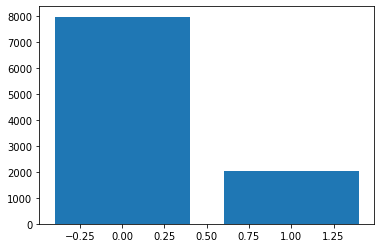

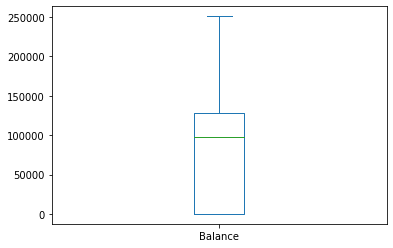

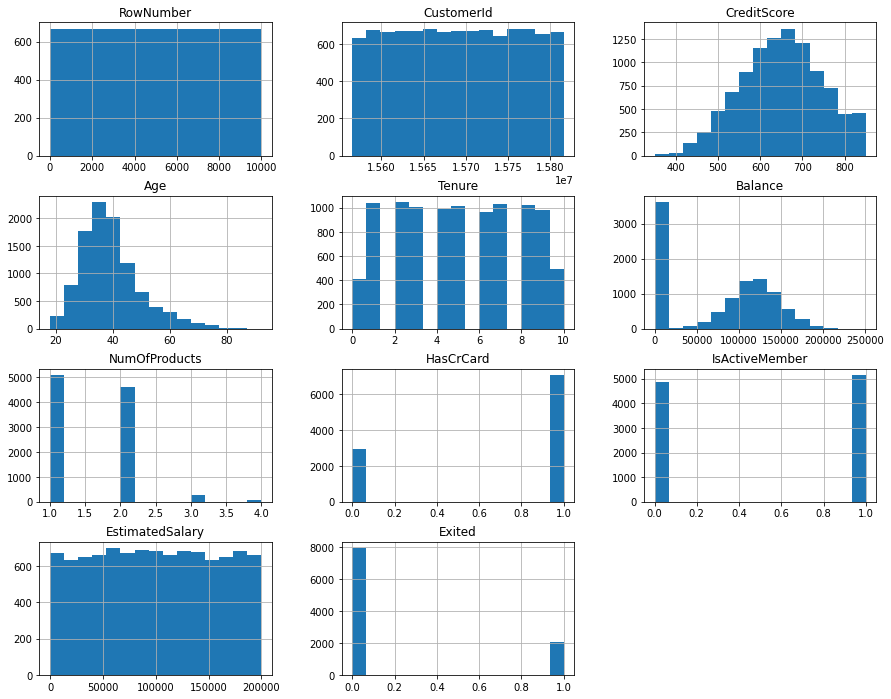

In [ ]:
# Visualizing the data's balance and values
a=df.shape
b=df.isnull().sum().any()
c=df.duplicated().sum()
print (a , " rows x columns, Any Null: ",b, ", contains",c, "duplicated rows")
balance = df['Exited'].value_counts().reset_index()
print(balance)
plt.bar(x= balance["index"], height = balance["Exited"], width =0.8)
plt.show(
)
df.Balance.plot(kind="box")

df.hist(figsize=(15, 12), bins=15);


We check the imbalance for a starter, we would divide majority class / (majority class + minority class) , if this value exceed 0.75 we could consider that our dataset is imbalance. This metric is the IR , it is most used to determine imbalance in a data source, it could be missleading when there's more than one class, since its not our case we are safe to use the imbalance rate.

The computed value is 0.7963 ~ 0.8, so our dataset is imbalanced.

In [ ]:
(df['Exited'].value_counts()[0] / (df['Exited'].value_counts()[0] +  df['Exited'].value_counts()[1]))

0.7963

No missing values so we do not have to fill values

## Age and Correlation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


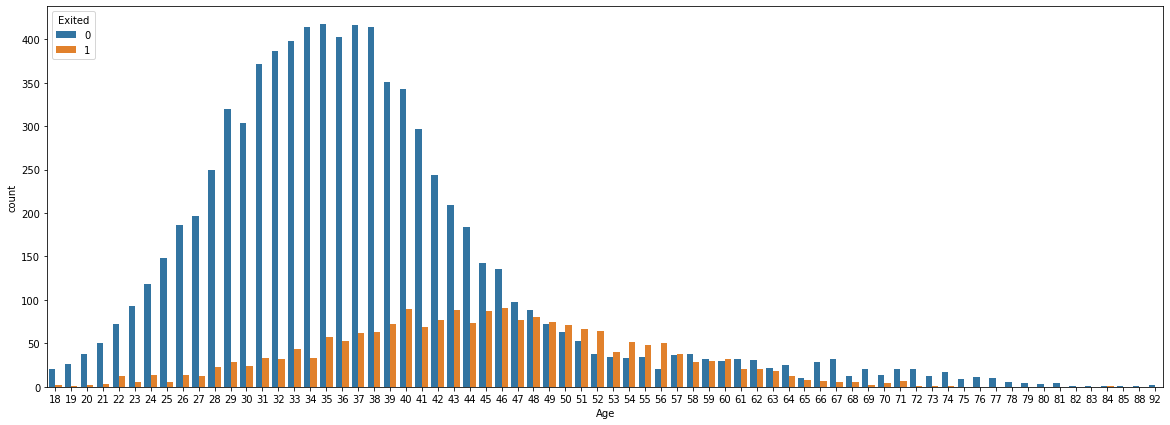

In [ ]:
# Identificamos aqui como la edad va a ser un factor muy importante

plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);


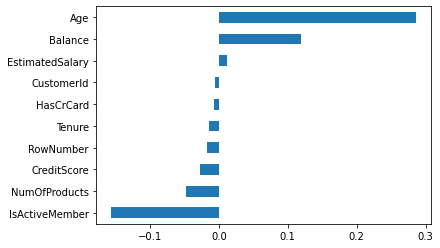

In [ ]:
df.corr()['Exited'][:-1].sort_values().plot.barh();

## Sensible Data and pseudo anonymized data.

First step with fauturs treatmnt is to deleter all sensible and Anonymisation and pseudonymisation data, this is , any information relative to the client of the bank that could help to identify him/her, in this case we would remove the CustomerId and its surname.  We can also remove the _RowNumber_ since it doesnt add any value to the data.

In [ ]:

#def remove_irrational_values(df:pd.DataFrame) -> pd.DataFrame:
df.drop(['CustomerId', 'Surname','RowNumber'], axis=1, inplace=True)


# df.head(5)

## Categorical Data


To understand why we will change all categorical data to number, first we have to think like a machine, machines can only compute the numbers, it could not manage text, everything is translated to numbers and then it operates with it. Machine Learning algorithms fit into essentially the same case. 

There are different approachs to transform categorical into numerical values, the most used thecniques are One-Hot Encoding and Label Encoding. 


Label Encoding creates a set of values , for example if we had 3 values for a column, we would have 0 , 1 , 2. This is a really good approach when we have only 2 classes in a column, in our case, the gender column, tho we will use label enconder for this.


One-hot-encoding makes our training data more useful and expressive, and can be easily rescaled.One-hot-encoding is done by creating a column with true(1) or false(0) for the value of the column to which a hot-encoding is applied. So, if we have 3 text values, we would create 3 columns with 0 if the row is not the value and 1 if it is the sample value.

We would choose one hot encoding since we have few values in each column.

pandas 'function _get_dummies_ applies one hot encoding to the categorical columns.



We apply one hot encoding with pandas built-in function get_dummies() to geography ( subset of Germany,France or Spain)

In [ ]:
# object values are not good for inserting in the models, instead we are going to create a boolean for every string value in the dataset
df.Gender = LabelEncoder().fit_transform(df.Gender)
df_c = pd.get_dummies(df[['Geography','HasCrCard','IsActiveMember']])

In [ ]:
df_c.head()

,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,1,1,1,0,0
1,0,1,0,0,1
2,1,0,1,0,0
3,0,0,1,0,0
4,1,1,0,0,1


## Data Normalization


Scaling and normalization are some data preparation techniques that are frequently used in machine learning. The process of transforming the columns in a dataset to the same scale is referred to as scaling.

Normalization is the process of transforming the columns following a rule about adjusting values measured on different scales to a notionally common scale. In this case to a normal distribution.

We will use [Zscore](https://www.youtube.com/watch?v=16vAjsnazEM) as the norma.
Simply put, a z-score (also called a standard score) gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is.

Normalization doesnt need to be applied to all datasets with numeric columns, in this case we have values in a very high range. We have for example very small values for the variable Tenure and variables such as Estimated Salary and balance that comprise up to 6-digit numbers. In these cases it is best to apply some kind of data correction so that our algorithm is able to find more similarities.


In [ ]:
columns = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age']  ## Columns to modify
X_norm = pd.DataFrame()
## Subtract the mean, divide by standard deviation.
for col in columns:
    colMean = df[col].mean()
    colStdDev = df[col].std()
    X_norm[col] = df[col].apply(lambda x : (x - colMean) / colStdDev) 

In [ ]:
X_norm

,CreditScore,Balance,EstimatedSalary,Age
0,-0.326205,-1.225786,0.021885,0.293503
1,-0.440014,0.117344,0.216523,0.198154
2,-1.536717,1.332987,0.240675,0.293503
3,0.501496,-1.225786,-0.108912,0.007456
4,2.063781,0.785689,-0.365258,0.388852
...,...,...,...,...
9995,1.246426,-1.225786,-0.066416,0.007456
9996,-1.391870,-0.306363,0.027987,-0.373939
9997,0.604958,-1.225786,-1.008593,-0.278590
9998,1.256772,-0.022606,-0.125224,0.293503


## Merge categorical and numerical

Once we have applied all changes to both numeric and categorical data, we merged all feautres into one dataset, which is the one to be fed to the preprocessing stage.

In [ ]:
X=pd.concat([df_c,X_norm, df[['Gender','NumOfProducts']]],axis=1)

In [ ]:
X.head()

,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Balance,EstimatedSalary,Age,Gender,NumOfProducts
0,1,1,1,0,0,-0.326205,-1.225786,0.021885,0.293503,0,1
1,0,1,0,0,1,-0.440014,0.117344,0.216523,0.198154,0,1
2,1,0,1,0,0,-1.536717,1.332987,0.240675,0.293503,0,3
3,0,0,1,0,0,0.501496,-1.225786,-0.108912,0.007456,0,2
4,1,1,0,0,1,2.063781,0.785689,-0.365258,0.388852,0,1


## Data Splitting

Now we are going to split the train data , called X in the data science world and the target data, the feature to predict, commonly named y. 

We would split the data aswell into train data for the alghorithm to learn and test which contains the unseen data from the algorithm and would let us judge the algorithm performance.

80% of data will go into training and the 20% rest we will save it for predictions.


In [ ]:
#y.values.ravel()


In [ ]:
#X,y = df.drop(columns = ['Exited'], axis=1 ), df['Exited']


In [ ]:
np.shape(X)

(10000, 11)

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,df['Exited'],test_size= 0.2,  random_state = 42)

In [ ]:
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=0.5)

In [ ]:
np.shape(X_train)

(8000, 11)

In [ ]:
np.shape(y_train)

(8000,)

In [ ]:
X_train_ovr = X_train.to_numpy()

# Oversampling stage

As we have mentioned before, the dataset presents imbalance. For the oversampling techniques we are going to use SMOTE and its variations. 

Our selected algorithms will be the top 3 qualified algorithms in the Smote_Variants competition: Polynom_fit, ProSwyn and Lee

And Supervised Smote because according to Kovacs Paper Supervised Smote had a great imporvement when the imbalance ratio was low, such in out case where its about 0.8.

First we get the list of algorithms that support multiclass oversampling, since we have more than one feature, what *smote variants* does is oversampling each pair of features and creates the same amount of rows.

Disclamer: we would call the Smote Variants package _sv_ from now on. 

with the function sv.get_all_oversamplers_multiclass() we get a list of the oversamplers we could use on more than one feauture. 

We check that our selected variants are on that list.


## Smote 




[LINK to paper](https://www.researchgate.net/publication/221439119_A_Distance-Based_Over-Sampling_Method_for_Learning_from_Imbalanced_Data_Sets)

This the first imnplementation of SMOTE its the original one and it works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [ ]:
oversampler= sv.SMOTE(random_state=2)
X_samp_smote, y_samp_smote= oversampler.sample(X_train_ovr, y_train.values)

2022-07-21 14:05:47,514:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': 2}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': 2}")
2022-07-21 14:05:47,537:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2022-07-21 14:05:47,550:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


  ## Lee

[LINK to paper](https://www.researchgate.net/publication/254016960_Applying_Oversampling_Technique_Based_on_Data_Density_and_Cost-sensitive_SVM_to_Imbalanced_Learning)

 SMOTE algorithm is a simple and effective over-sampling technique. But SMOTE algorithm ignores data distribution and density information which is important to synthesize minority examples. SMOTE algorithm cannot effectively eliminate the influence of noise either. A novel over-sampling *algorithm-Lee* is proposed and shows better performance in experiments

In [ ]:
oversampler_Lee= sv.Lee(random_state=2)
X_samp_Lee, y_samp_Lee= oversampler_Lee.sample(X_train_ovr, y_train.values)

Se han truncado las últimas 5000 líneas del flujo de salida.
2022-07-21 14:06:17,256:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:17,262:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:17,272:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:17,276:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:17,291:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:17,296:INFO:NearestNeighborsWithMetricTensor: kneighbors query mink

## ProWSyn 
 [LINK to paper](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_27)

*Proximity Weighted Synthetic Oversampling Technique (ProWSyn)* generate effective weight values for the minority data
samples based on sample’s proximity information, i.e., distance from
boundary which results in a proper distribution of generated synthetic
samples across the minority data set. Simulation results on some real
world datasets shows the effectiveness of the proposed method showing
improvements in various assessment metrics such as AUC, F-measure,
and G-mean.



In [ ]:
oversampler_ProWSyn= sv.ProWSyn(random_state = 2)
X_samp_ProWSyn, y_samp_ProWSyn= oversampler_ProWSyn.sample(X_train_ovr, y_train.values)

2022-07-21 14:06:51,208:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 2}")
INFO:smote_variants:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 2}")
2022-07-21 14:06:51,221:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2022-07-21 14:06:51,232:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2022-07-21 14:06:51,921:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2022-07-21 14:06:51,926:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_varia

## Supervised_SMOTE

[LINK to paper](https://ieeexplore.ieee.org/document/6976968)

In [ ]:
oversampler_Supervised= sv.Supervised_SMOTE(random_state= 2)
X_samp_Supervised, y_samp_Supervised= oversampler_Supervised.sample(X_train_ovr, y_train.values)

2022-07-21 14:06:54,351:INFO:Supervised_SMOTE: Running sampling via ('Supervised_SMOTE', "{'proportion': 1.0, 'th_lower': 0.5, 'th_upper': 1.0, 'classifier': RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=5), 'n_jobs': 1, 'random_state': 2}")
INFO:smote_variants:Supervised_SMOTE: Running sampling via ('Supervised_SMOTE', "{'proportion': 1.0, 'th_lower': 0.5, 'th_upper': 1.0, 'classifier': RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=5), 'n_jobs': 1, 'random_state': 2}")


## polynom_fit_SMOTE

[LINK to paper](https://www.researchgate.net/publication/220933172_New_Oversampling_Approaches_Based_on_Polynomial_Fitting_for_Imbalanced_Data_Sets)

*Poly-fit Smote* is based on oversampling the minority
class using polynomial fitting functions. Four new
approaches were proposed: star topology, bus
topology, polynomial curve topology and mesh
topology. Star and mesh topologies approach had led
to the best performances. 

In [ ]:
oversampler_poly_SMOTE= sv.polynom_fit_SMOTE( random_state= 2)
X_samp_poly_SMOTE, y_samp_poly_SMOTE= oversampler_poly_SMOTE.sample(X_train_ovr, y_train.values)

2022-07-21 14:08:43,034:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 2}")
INFO:smote_variants:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 2}")


# Algorithm predictions

+

In [ ]:
macro_avg_list = []
metrics_list = []

## Adaboost 

through different iterations changing values till finding the best values we will find the best model , we will change n_estimators, then learning rate which usually goes according the n_estimators and finally the Base estimator with the number of nodes it can go down .

In [ ]:



# def Tunning_AdaBoost(X,Y) -> list:
#     # scorer = make_scorer(auc)
#     clf_ada = AdaBoostClassifier()
    
#     # clf_ada.fit(X,Y)
#     # ada_predictions = clf_ada.predict(X_test)
#     parameters = {
#                   #'n_estimators': 5000,
#                  #'learning_rate': 0.001,
#                   'base_estimator':[DecisionTreeClassifier(max_depth=15),DecisionTreeClassifier(max_depth=20),DecisionTreeClassifier(max_depth=25)]
#                   }
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     grid_init = GridSearchCV(clf_ada, parameters, n_jobs=-1, cv=cv, scoring='recall')
#     grid_fit = grid_init.fit(X, Y)
#     best_clf_ada = grid_fit.best_estimator_
#     return best_clf_ada

In [ ]:
#ada_model = Tunning_AdaBoost(X_samp_smote,y_samp_smote)

N_estimators:

- first iteration: 500 n_estimators, we try from 10 to 500
- second iteration:  1000 selected, we try from 300 to 1000
- third iteration:  5000, we try from 1000 to 7000

Learning_rate:
- first iteration: 0.001 , we try 0.001 , 0.01, 0,1 and 1

base_estimator:
- first iteration: 10, we try 2 8 and 10 max depth
- second iteration: 20, we try 10 20 30
- third iterati0n:  20, we try 15 20 25

In [ ]:
#ada_model.get_params

In [ ]:
model_opt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=5000 , learning_rate= 0.001)

### AdaBoost Predictions Function -> Input each oversampler dataset

In [ ]:
def predictions_ada(X_train, X_test , y_train,ovr):
  model_opt.fit(X_train, y_train)
  best_predictions_ada = model_opt.predict(pd.concat([X_test,X_valid], axis=0))
  acc = accuracy_score(pd.concat([y_test,y_valid], axis=0), best_predictions_ada)
  recall = recall_score(pd.concat([y_test,y_valid], axis=0), best_predictions_ada)
  f1 = f1_score(pd.concat([y_test,y_valid], axis=0), best_predictions_ada)
  metrics_list.append( [ovr,'AdaBoost',acc,recall,f1] )
  macro_metrics = (classification_report(pd.concat([y_test,y_valid], axis=0),best_predictions_ada,output_dict=True)['macro avg'])
  macro_metrics['ovr'] = ovr
  macro_metrics['alg'] = 'AdaBoost'
  macro_metrics['acc'] = acc
  macro_avg_list.append(macro_metrics)
  return  acc, recall, f1

### Predicted values

In [ ]:
acc_ada,rec_ada,f1_ada  = predictions_ada(X_train,X_test,y_train, 'No-Smote')

In [ ]:
print(acc_ada,rec_ada,f1_ada)

0.798 0.5063613231552163 0.4962593516209476


In [ ]:
acc_smote_ada,rec_smote_ada,f1_smote_ada  = predictions_ada(X_samp_smote, X_test, y_samp_smote,'Smote')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(acc_smote_ada, rec_smote_ada)

0.7885 0.5521628498727735


In [ ]:
acc_Lee_ada,rec_Lee_ada,f1_Lee_ada  = predictions_ada(X_samp_Lee, X_test, y_samp_Lee,'Lee')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(acc_Lee_ada, rec_Lee_ada)

0.786 0.549618320610687


In [ ]:
acc_ProWSyn_ada,rec_ProWSyn_ada,f1_ProWSyn_ada =predictions_ada(X_samp_ProWSyn, X_test, y_samp_ProWSyn,'ProWSyn')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(acc_ProWSyn_ada, rec_ProWSyn_ada)

0.7965 0.5318066157760815


In [ ]:
acc_Supervised_ada,rec_Supervised_ada,f1_Supervised_ada = predictions_ada(X_samp_Supervised, X_test, y_samp_Supervised,'Supervised-Smote')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(acc_Supervised_ada,rec_Supervised_ada)

0.796 0.5343511450381679


In [ ]:
acc_poly_ada,rec_poly_ada,f1_poly_ada =  predictions_ada(X_samp_poly_SMOTE, X_test, y_samp_poly_SMOTE,'Polynom_fit')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(acc_poly_ada,rec_poly_ada)

0.8 0.5139949109414759



## xGBoost
----
[LINK paper](https://arxiv.org/pdf/1603.02754.pdf)
---
[LINK demo](https://www.themachinelearners.com/xgboost-python/)

XGBoost works as Newton-Raphson in function space unlike gradient boosting that works as gradient descent in function space, a second order Taylor approximation is used in the loss function to make the connection to Newton Raphson method.



### Grid Search

In [ ]:
Accuracy_XGBoost = ['XGBoost']

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params2 = { "objective":"binary:logistic",'colsample_bytree':0.5,
                'max_depth': 6,  'n_estimators':1000, 'min_child_weight':5 }
classifier = XGBClassifier(**params2)
params={
 "learning_rate"    : [ 0.15, 0.45, 0.46, 0.47, 0.48 ] ,
 "max_depth"        : [4, 5, 6, 8],
 "gamma"            : [0.2, 0.3,0.35,0.4],
 "colsample_bytree" : [0.45, 0.5 ,0.55,0.6]
    
}
random_search=GridSearchCV(classifier,param_grid=params,scoring='recall',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

In [ ]:
# model = random_search.best_estimator_

In [ ]:
# print(model)

### plot matrix
> Confidence Matrix to check instances

In [ ]:

import seaborn as sns

def plot_matrix(y_pred):
  cf_matrix = confusion_matrix(y_test,y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
              cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  return labels , cf_matrix
  

### XGBoost Predictions Function -> Input each oversampler dataset

In [ ]:
def XGBoost2(X_train,X_test, y_train):
  data_dmatrix = DMatrix(data= X_train,label=y_train, feature_names =list(X.columns.values) )
  test_dmatrix = DMatrix(data=X_test, feature_names =list(X.columns.values))
  val_metrix = DMatrix(data=X_valid,label=y_valid, feature_names =list(X.columns.values) )
  params = { "objective":"binary:logistic",'colsample_bytree':0.5,'learning_rate': 0.025,
                  'max_depth': 4, 'gamma': 0.3, 'subsample':0.66, 'n_estimators':1000, 'min_child_weight':5 , 'seed':24}
  evallist  = [(val_metrix, 'eval')]
  # xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
  #                     num_boost_round=50, early_stopping_rounds=20,  as_pandas=True, seed=123)
  b = xgb.train(dtrain=data_dmatrix, params=params, evals =evallist , num_boost_round=50)
  predictions = b.predict(test_dmatrix)
  real_predictions = list(np.where(np.array(predictions) > 0.50, 1, 0 ))
  return real_predictions

In [ ]:
def predictions_xgb(predictions, ovr):
  acc = accuracy_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  pred_list =  [ovr, 'XGB', acc, recall,f1]
  macro_metrics = (classification_report(y_test,predictions,output_dict=True)['macro avg'])
  macro_metrics['ovr'] = ovr
  macro_metrics['alg'] = 'XGB'
  macro_metrics['acc'] = acc
  macro_avg_list.append(macro_metrics)
  metrics_list.append(pred_list)
  return  pred_list

[0]	eval-error:0.149
[1]	eval-error:0.164
[2]	eval-error:0.15
[3]	eval-error:0.14
[4]	eval-error:0.15
[5]	eval-error:0.167
[6]	eval-error:0.146
[7]	eval-error:0.149
[8]	eval-error:0.145
[9]	eval-error:0.142
[10]	eval-error:0.142
[11]	eval-error:0.141
[12]	eval-error:0.145
[13]	eval-error:0.153
[14]	eval-error:0.154
[15]	eval-error:0.156
[16]	eval-error:0.156
[17]	eval-error:0.156
[18]	eval-error:0.156
[19]	eval-error:0.153
[20]	eval-error:0.151
[21]	eval-error:0.151
[22]	eval-error:0.151
[23]	eval-error:0.151
[24]	eval-error:0.15
[25]	eval-error:0.148
[26]	eval-error:0.142
[27]	eval-error:0.145
[28]	eval-error:0.143
[29]	eval-error:0.141
[30]	eval-error:0.142
[31]	eval-error:0.14
[32]	eval-error:0.141
[33]	eval-error:0.142
[34]	eval-error:0.141
[35]	eval-error:0.142
[36]	eval-error:0.14
[37]	eval-error:0.141
[38]	eval-error:0.139
[39]	eval-error:0.141
[40]	eval-error:0.141
[41]	eval-error:0.139
[42]	eval-error:0.139
[43]	eval-error:0.139
[44]	eval-error:0.139
[45]	eval-error:0.139
[46]

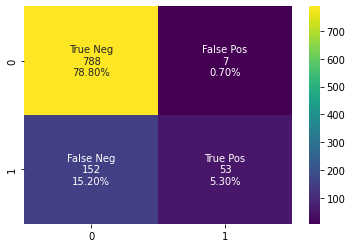

In [ ]:
y_pred_XGB = XGBoost2(X_train.values,X_test,y_train.values)
print(predictions_xgb(y_pred_XGB,'No-Smote')) 
labels , cf_matrix = plot_matrix(y_pred_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")
sns.color_palette("rocket", as_cmap=True)

[0]	eval-error:0.163
[1]	eval-error:0.2
[2]	eval-error:0.227
[3]	eval-error:0.189
[4]	eval-error:0.19
[5]	eval-error:0.209
[6]	eval-error:0.189
[7]	eval-error:0.186
[8]	eval-error:0.19
[9]	eval-error:0.198
[10]	eval-error:0.205
[11]	eval-error:0.21
[12]	eval-error:0.184
[13]	eval-error:0.189
[14]	eval-error:0.193
[15]	eval-error:0.179
[16]	eval-error:0.174
[17]	eval-error:0.167
[18]	eval-error:0.17
[19]	eval-error:0.164
[20]	eval-error:0.167
[21]	eval-error:0.17
[22]	eval-error:0.169
[23]	eval-error:0.171
[24]	eval-error:0.171
[25]	eval-error:0.17
[26]	eval-error:0.172
[27]	eval-error:0.173
[28]	eval-error:0.176
[29]	eval-error:0.176
[30]	eval-error:0.174
[31]	eval-error:0.17
[32]	eval-error:0.169
[33]	eval-error:0.171
[34]	eval-error:0.171
[35]	eval-error:0.168
[36]	eval-error:0.171
[37]	eval-error:0.162
[38]	eval-error:0.17
[39]	eval-error:0.168
[40]	eval-error:0.17
[41]	eval-error:0.17
[42]	eval-error:0.166
[43]	eval-error:0.167
[44]	eval-error:0.164
[45]	eval-error:0.169
[46]	eval-

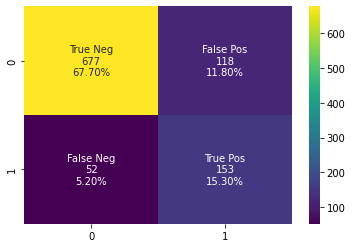

In [ ]:
y_pred_smote_XGB = XGBoost2(X_samp_smote, X_test, y_samp_smote)
print(predictions_xgb(y_pred_smote_XGB,'Smote')) 
labels , cf_matrix = plot_matrix(y_pred_smote_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")


[0]	eval-error:0.183
[1]	eval-error:0.2
[2]	eval-error:0.212
[3]	eval-error:0.197
[4]	eval-error:0.193
[5]	eval-error:0.201
[6]	eval-error:0.186
[7]	eval-error:0.186
[8]	eval-error:0.193
[9]	eval-error:0.202
[10]	eval-error:0.206
[11]	eval-error:0.201
[12]	eval-error:0.179
[13]	eval-error:0.189
[14]	eval-error:0.192
[15]	eval-error:0.173
[16]	eval-error:0.175
[17]	eval-error:0.176
[18]	eval-error:0.173
[19]	eval-error:0.172
[20]	eval-error:0.172
[21]	eval-error:0.166
[22]	eval-error:0.173
[23]	eval-error:0.172
[24]	eval-error:0.177
[25]	eval-error:0.176
[26]	eval-error:0.175
[27]	eval-error:0.17
[28]	eval-error:0.171
[29]	eval-error:0.17
[30]	eval-error:0.168
[31]	eval-error:0.172
[32]	eval-error:0.168
[33]	eval-error:0.171
[34]	eval-error:0.17
[35]	eval-error:0.169
[36]	eval-error:0.165
[37]	eval-error:0.167
[38]	eval-error:0.169
[39]	eval-error:0.17
[40]	eval-error:0.169
[41]	eval-error:0.172
[42]	eval-error:0.172
[43]	eval-error:0.174
[44]	eval-error:0.174
[45]	eval-error:0.172
[46]

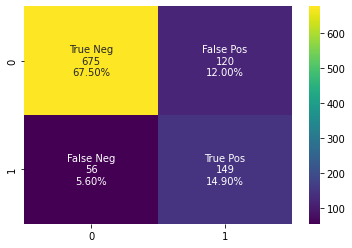

In [ ]:
y_pred_Lee_XGB = XGBoost2(X_samp_Lee,X_test,y_samp_Lee)
print(predictions_xgb(y_pred_Lee_XGB,'Lee')) 
labels , cf_matrix = plot_matrix(y_pred_Lee_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")


[0]	eval-error:0.167
[1]	eval-error:0.167
[2]	eval-error:0.148
[3]	eval-error:0.146
[4]	eval-error:0.152
[5]	eval-error:0.158
[6]	eval-error:0.143
[7]	eval-error:0.145
[8]	eval-error:0.16
[9]	eval-error:0.165
[10]	eval-error:0.165
[11]	eval-error:0.158
[12]	eval-error:0.16
[13]	eval-error:0.156
[14]	eval-error:0.154
[15]	eval-error:0.156
[16]	eval-error:0.149
[17]	eval-error:0.151
[18]	eval-error:0.146
[19]	eval-error:0.142
[20]	eval-error:0.145
[21]	eval-error:0.14
[22]	eval-error:0.142
[23]	eval-error:0.143
[24]	eval-error:0.141
[25]	eval-error:0.145
[26]	eval-error:0.147
[27]	eval-error:0.147
[28]	eval-error:0.139
[29]	eval-error:0.145
[30]	eval-error:0.138
[31]	eval-error:0.139
[32]	eval-error:0.144
[33]	eval-error:0.148
[34]	eval-error:0.142
[35]	eval-error:0.139
[36]	eval-error:0.137
[37]	eval-error:0.137
[38]	eval-error:0.136
[39]	eval-error:0.137
[40]	eval-error:0.138
[41]	eval-error:0.139
[42]	eval-error:0.138
[43]	eval-error:0.138
[44]	eval-error:0.138
[45]	eval-error:0.137
[

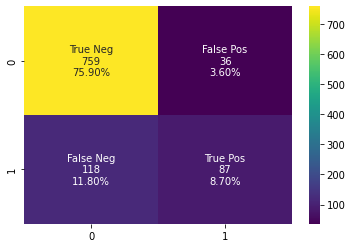

In [ ]:
y_pred_ProWSyn_XGB = XGBoost2(X_samp_ProWSyn,X_test,y_samp_ProWSyn)
print(predictions_xgb(y_pred_ProWSyn_XGB, 'ProWSyn')) 
labels , cf_matrix = plot_matrix(y_pred_ProWSyn_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")


[0]	eval-error:0.167
[1]	eval-error:0.167
[2]	eval-error:0.148
[3]	eval-error:0.146
[4]	eval-error:0.152
[5]	eval-error:0.158
[6]	eval-error:0.143
[7]	eval-error:0.145
[8]	eval-error:0.16
[9]	eval-error:0.165
[10]	eval-error:0.165
[11]	eval-error:0.158
[12]	eval-error:0.16
[13]	eval-error:0.156
[14]	eval-error:0.154
[15]	eval-error:0.156
[16]	eval-error:0.149
[17]	eval-error:0.151
[18]	eval-error:0.146
[19]	eval-error:0.142
[20]	eval-error:0.145
[21]	eval-error:0.14
[22]	eval-error:0.142
[23]	eval-error:0.143
[24]	eval-error:0.141
[25]	eval-error:0.145
[26]	eval-error:0.147
[27]	eval-error:0.147
[28]	eval-error:0.139
[29]	eval-error:0.145
[30]	eval-error:0.138
[31]	eval-error:0.139
[32]	eval-error:0.144
[33]	eval-error:0.148
[34]	eval-error:0.142
[35]	eval-error:0.139
[36]	eval-error:0.137
[37]	eval-error:0.137
[38]	eval-error:0.136
[39]	eval-error:0.137
[40]	eval-error:0.138
[41]	eval-error:0.139
[42]	eval-error:0.138
[43]	eval-error:0.138
[44]	eval-error:0.138
[45]	eval-error:0.137
[

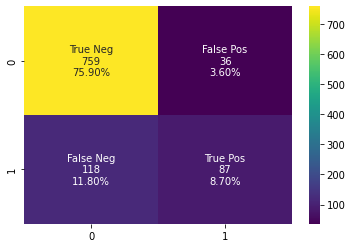

In [ ]:
y_pred_Supervised_SMOTE_XGB = XGBoost2(X_samp,X_test,y_samp_Supervised)
print(predictions_xgb(y_pred_Supervised_SMOTE_XGB,'Supervised-Smote')) 
labels , cf_matrix = plot_matrix(y_pred_Supervised_SMOTE_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")


[0]	eval-error:0.146
[1]	eval-error:0.133
[2]	eval-error:0.141
[3]	eval-error:0.142
[4]	eval-error:0.142
[5]	eval-error:0.151
[6]	eval-error:0.155
[7]	eval-error:0.153
[8]	eval-error:0.159
[9]	eval-error:0.157
[10]	eval-error:0.158
[11]	eval-error:0.162
[12]	eval-error:0.159
[13]	eval-error:0.158
[14]	eval-error:0.157
[15]	eval-error:0.157
[16]	eval-error:0.157
[17]	eval-error:0.157
[18]	eval-error:0.154
[19]	eval-error:0.152
[20]	eval-error:0.153
[21]	eval-error:0.153
[22]	eval-error:0.152
[23]	eval-error:0.152
[24]	eval-error:0.152
[25]	eval-error:0.151
[26]	eval-error:0.152
[27]	eval-error:0.15
[28]	eval-error:0.152
[29]	eval-error:0.152
[30]	eval-error:0.152
[31]	eval-error:0.152
[32]	eval-error:0.152
[33]	eval-error:0.152
[34]	eval-error:0.153
[35]	eval-error:0.153
[36]	eval-error:0.152
[37]	eval-error:0.153
[38]	eval-error:0.153
[39]	eval-error:0.151
[40]	eval-error:0.151
[41]	eval-error:0.15
[42]	eval-error:0.15
[43]	eval-error:0.15
[44]	eval-error:0.15
[45]	eval-error:0.149
[46

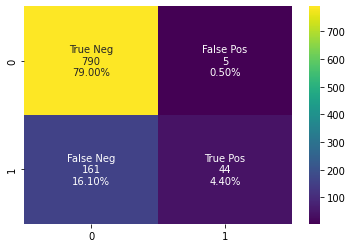

In [ ]:
y_pred_poly_XGB = XGBoost2(X_samp_poly_SMOTE,X_test,y_samp_poly_SMOTE)
print(predictions_xgb(y_pred_poly_XGB,'Polynom_fit')) 
labels , cf_matrix = plot_matrix(y_pred_poly_XGB)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="viridis")


##LightGBM
----

[LINK paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
---
[LINK demo](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.


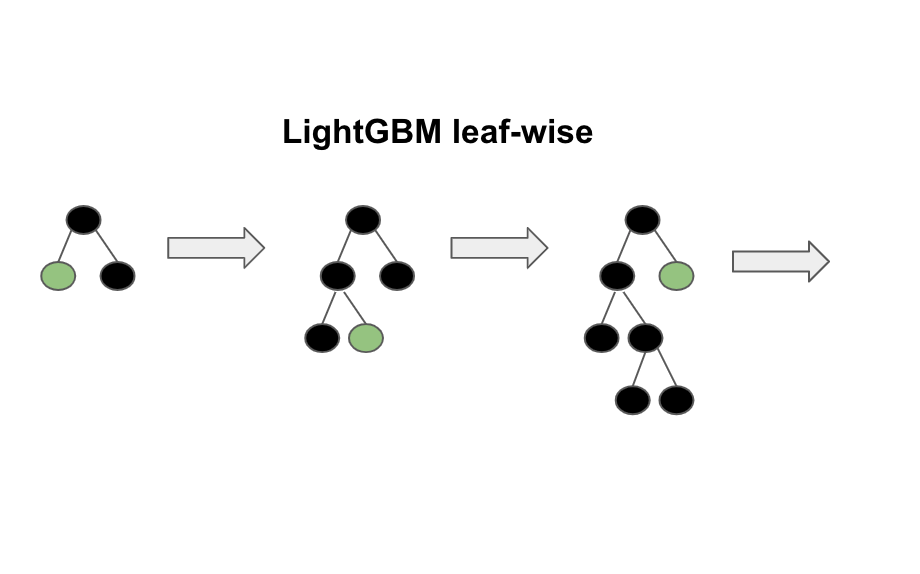



In [ ]:
Accuracy_lgb = ['LightGBM']

### Optimization 

In [ ]:
from numpy.core.multiarray import result_type
from seaborn.rcmod import reset_defaults
import lightgbm as lgb  
import numpy as np
def lightgbm(X_train,X_test,y_train,y_test) -> list:
    lgb_train = lgb.Dataset(X_train, y_train)  
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)  

    params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': {'binary_logloss', 'auc'},  # Pérdida logarítmica binaria
    'num_leaves': 85,  
    'max_depth': 7,  
    'min_data_in_leaf': 15,  
    'learning_rate': 0.13118560097934115,  
    'feature_fraction': 0.5,  
    'bagging_fraction': 0.95,  
    'bagging_freq': 1,  
    'lambda_l1': 95,    
    'lambda_l2': 30,  # Cuanto menor es la regularidad l2, mayor es  
    'min_gain_to_split': 3.0397484168047435,  
    'verbose': 5,
    'seed' : 19,  
    'is_unbalance': False  
      }
    # params = {'bagging_fraction': 0.7,
    #           'bagging_freq': 1,
    #           'feature_fraction': 0.9,
    #           'metric': 'binary_logloss',
    #           'lambda_l1': 30,
    #           'lambda_l2': 70,
    #           'learning_rate': 0.29504610889929545,
    #           'max_depth': 3,
    #           'min_data_in_leaf': 200,
    #           'min_gain_to_split': 9.975577365886458,
    #           'n_estimators': 10000,
    #           'num_leaves': 100}


    gbm = lgb.train(params,  
                lgb_train,  
                num_boost_round=10000,  
                valid_sets=lgb_eval,  
                early_stopping_rounds=500)  
    #simple one
  

    LGBM_predictions = gbm.predict(X_test, num_iteration=gbm.best_iteration) 
    print(LGBM_predictions)
    return LGBM_predictions

## Metrics Table

 ### LGBM Predictions Function -> Input each oversampler dataset

In [ ]:
def predictions_lgb(predictions, ovr):
  acc = accuracy_score(y_test, predictions)
  print(predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  pred_list =  [ovr, 'LGBM', acc, recall,f1]
  metrics_list.append(pred_list)
  macro_metrics = (classification_report(y_test,predictions,output_dict=True)['macro avg'])
  macro_metrics['ovr'] = ovr
  macro_metrics['alg'] = 'LGNM'
  macro_metrics['acc'] = acc
  macro_avg_list.append(macro_metrics)

  return  print(pred_list)

In [ ]:
y_pred_lgb = lightgbm(X_train,X_test,y_train,y_test)
a = np.vectorize(lambda x: int(x >= 0.5))(y_pred_lgb)
predictions_lgb(a, 'no_smote')

[1]	valid_0's auc: 0.742942	valid_0's binary_logloss: 0.474716
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.752879	valid_0's binary_logloss: 0.471675
[3]	valid_0's auc: 0.760792	valid_0's binary_logloss: 0.464509
[4]	valid_0's auc: 0.829217	valid_0's binary_logloss: 0.453311
[5]	valid_0's auc: 0.840645	valid_0's binary_logloss: 0.451706
[6]	valid_0's auc: 0.837704	valid_0's binary_logloss: 0.443332
[7]	valid_0's auc: 0.837612	valid_0's binary_logloss: 0.441559
[8]	valid_0's auc: 0.834736	valid_0's binary_logloss: 0.433759
[9]	valid_0's auc: 0.836286	valid_0's binary_logloss: 0.425892
[10]	valid_0's auc: 0.83601	valid_0's binary_logloss: 0.419788
[11]	valid_0's auc: 0.840019	valid_0's binary_logloss: 0.414496
[12]	valid_0's auc: 0.845247	valid_0's binary_logloss: 0.412648
[13]	valid_0's auc: 0.845764	valid_0's binary_logloss: 0.412459
[14]	valid_0's auc: 0.840668	valid_0's binary_logloss: 0.409258
[15]	valid_0's auc: 0.8449	valid_0's binary_logloss

In [ ]:
y_pred_lgb_smote = lightgbm(X_samp_smote,X_test,y_samp_smote,y_test)
y_pred_lgb_smote =  np.around(y_pred_lgb_smote)
predictions_lgb(y_pred_lgb_smote, 'Smote')

[1]	valid_0's auc: 0.746761	valid_0's binary_logloss: 0.665981
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.761762	valid_0's binary_logloss: 0.660221
[3]	valid_0's auc: 0.768597	valid_0's binary_logloss: 0.640201
[4]	valid_0's auc: 0.827757	valid_0's binary_logloss: 0.621956
[5]	valid_0's auc: 0.835083	valid_0's binary_logloss: 0.613781
[6]	valid_0's auc: 0.849315	valid_0's binary_logloss: 0.600445
[7]	valid_0's auc: 0.850743	valid_0's binary_logloss: 0.591058
[8]	valid_0's auc: 0.850799	valid_0's binary_logloss: 0.573419
[9]	valid_0's auc: 0.852043	valid_0's binary_logloss: 0.559227
[10]	valid_0's auc: 0.85337	valid_0's binary_logloss: 0.545492
[11]	valid_0's auc: 0.852413	valid_0's binary_logloss: 0.536596
[12]	valid_0's auc: 0.853383	valid_0's binary_logloss: 0.531912
[13]	valid_0's auc: 0.853733	valid_0's binary_logloss: 0.531388
[14]	valid_0's auc: 0.852476	valid_0's binary_logloss: 0.526793
[15]	valid_0's auc: 0.852128	valid_0's binary_loglo

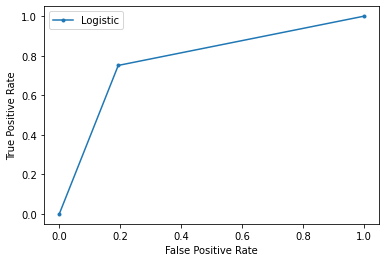

In [ ]:

lr_auc = roc_auc_score(y_test, np.around(y_pred_lgb_smote))
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_lgb_smote)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
y_pred_Lee_lgb = lightgbm(X_samp_Lee,X_test,y_samp_Lee,y_test)
a = np.vectorize(lambda x: int(x >= 0.5))(y_pred_Lee_lgb)
predictions_lgb(a, 'Lee')

[1]	valid_0's auc: 0.747016	valid_0's binary_logloss: 0.665272
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.757923	valid_0's binary_logloss: 0.660161
[3]	valid_0's auc: 0.766226	valid_0's binary_logloss: 0.639883
[4]	valid_0's auc: 0.825067	valid_0's binary_logloss: 0.621596
[5]	valid_0's auc: 0.833983	valid_0's binary_logloss: 0.613371
[6]	valid_0's auc: 0.849793	valid_0's binary_logloss: 0.59896
[7]	valid_0's auc: 0.849315	valid_0's binary_logloss: 0.593322
[8]	valid_0's auc: 0.851054	valid_0's binary_logloss: 0.575517
[9]	valid_0's auc: 0.852492	valid_0's binary_logloss: 0.560856
[10]	valid_0's auc: 0.853357	valid_0's binary_logloss: 0.546655
[11]	valid_0's auc: 0.852485	valid_0's binary_logloss: 0.537454
[12]	valid_0's auc: 0.853609	valid_0's binary_logloss: 0.532573
[13]	valid_0's auc: 0.853474	valid_0's binary_logloss: 0.532374
[14]	valid_0's auc: 0.85277	valid_0's binary_logloss: 0.52755
[15]	valid_0's auc: 0.852607	valid_0's binary_logloss

In [ ]:
y_pred_ProWSyn_lgb = lightgbm(X_samp_ProWSyn,X_test,y_samp_ProWSyn,y_test)
a = np.vectorize(lambda x: int(x >= 0.5))(y_pred_ProWSyn_lgb)
predictions_lgb(a, 'ProWSyn')

[1]	valid_0's auc: 0.756059	valid_0's binary_logloss: 0.650017
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.730512	valid_0's binary_logloss: 0.629161
[3]	valid_0's auc: 0.772698	valid_0's binary_logloss: 0.596629
[4]	valid_0's auc: 0.817714	valid_0's binary_logloss: 0.574069
[5]	valid_0's auc: 0.82565	valid_0's binary_logloss: 0.556837
[6]	valid_0's auc: 0.835807	valid_0's binary_logloss: 0.541922
[7]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.527788
[8]	valid_0's auc: 0.835768	valid_0's binary_logloss: 0.511732
[9]	valid_0's auc: 0.844716	valid_0's binary_logloss: 0.495358
[10]	valid_0's auc: 0.841005	valid_0's binary_logloss: 0.485895
[11]	valid_0's auc: 0.844405	valid_0's binary_logloss: 0.474497
[12]	valid_0's auc: 0.842993	valid_0's binary_logloss: 0.467945
[13]	valid_0's auc: 0.841372	valid_0's binary_logloss: 0.463269
[14]	valid_0's auc: 0.841333	valid_0's binary_logloss: 0.458341
[15]	valid_0's auc: 0.845191	valid_0's binary_loglo

In [ ]:
y_pred_Supervised_SMOTE_lgb = lightgbm(X_samp_Supervised,X_test,y_samp_Supervised,y_test)
a = np.vectorize(lambda x: int(x >= 0.5))(y_pred_Supervised_SMOTE_lgb)
predictions_lgb(a, 'Supervised-Smote')

[1]	valid_0's auc: 0.752319	valid_0's binary_logloss: 0.651191
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.736689	valid_0's binary_logloss: 0.63112
[3]	valid_0's auc: 0.76186	valid_0's binary_logloss: 0.602842
[4]	valid_0's auc: 0.818438	valid_0's binary_logloss: 0.578003
[5]	valid_0's auc: 0.828284	valid_0's binary_logloss: 0.561073
[6]	valid_0's auc: 0.840426	valid_0's binary_logloss: 0.541342
[7]	valid_0's auc: 0.840576	valid_0's binary_logloss: 0.527797
[8]	valid_0's auc: 0.847094	valid_0's binary_logloss: 0.505945
[9]	valid_0's auc: 0.848879	valid_0's binary_logloss: 0.488026
[10]	valid_0's auc: 0.848073	valid_0's binary_logloss: 0.474952
[11]	valid_0's auc: 0.853452	valid_0's binary_logloss: 0.461746
[12]	valid_0's auc: 0.852914	valid_0's binary_logloss: 0.455799
[13]	valid_0's auc: 0.85258	valid_0's binary_logloss: 0.451872
[14]	valid_0's auc: 0.850573	valid_0's binary_logloss: 0.446505
[15]	valid_0's auc: 0.853999	valid_0's binary_logloss

In [ ]:
y_pred_poly_lgb = lightgbm(X_samp_poly_SMOTE,X_test,y_samp_poly_SMOTE,y_test)
a = np.vectorize(lambda x: int(x >= 0.5))(y_pred_poly_lgb)
predictions_lgb(a, 'Polynom_fit')

[1]	valid_0's auc: 0.65552	valid_0's binary_logloss: 0.652904
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.674523	valid_0's binary_logloss: 0.616123
[3]	valid_0's auc: 0.731445	valid_0's binary_logloss: 0.584619
[4]	valid_0's auc: 0.787401	valid_0's binary_logloss: 0.555789
[5]	valid_0's auc: 0.795966	valid_0's binary_logloss: 0.538991
[6]	valid_0's auc: 0.811619	valid_0's binary_logloss: 0.522863
[7]	valid_0's auc: 0.80217	valid_0's binary_logloss: 0.509357
[8]	valid_0's auc: 0.808655	valid_0's binary_logloss: 0.492501
[9]	valid_0's auc: 0.831582	valid_0's binary_logloss: 0.474485
[10]	valid_0's auc: 0.834229	valid_0's binary_logloss: 0.465169
[11]	valid_0's auc: 0.840222	valid_0's binary_logloss: 0.454392
[12]	valid_0's auc: 0.838015	valid_0's binary_logloss: 0.44864
[13]	valid_0's auc: 0.841241	valid_0's binary_logloss: 0.444735
[14]	valid_0's auc: 0.84001	valid_0's binary_logloss: 0.438167
[15]	valid_0's auc: 0.841837	valid_0's binary_logloss:

### Macro Avg

In [ ]:
df_avg = pd.DataFrame(macro_avg_list)
df_top_rec = df_avg.sort_values(by='recall' , ascending= False).head()

In [ ]:
df_top_rec.to_csv('df_top_rec.csv')
df.to_csv('df_values.csv')
df_m.to_csv('df_values_melt.csv')

## Hyperparameter tunning
> We have search with optuna the best parameters for LGBM

### optuna 

In [ ]:
!pip install optuna

In [ ]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
  param_grid = {
      # "device_type": trial.suggest_categorical("device_type", ['gpu']),
      "n_estimators": trial.suggest_int("n_estimators", 100 , 1000),
      "learning_rate": trial.suggest_float("learning_rate", 0.025, 0.3),
      "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
      "max_depth": trial.suggest_int("max_depth", 3, 12),
      "subsample": trial.suggest_float("subsample",0.66,1 ),
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 1000, step=10),
      "feature_fraction": trial.suggest_float(
          "feature_fraction", 0.2, 0.95, step=0.1
      ),
  }

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)

  cv_scores = np.empty(5)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]

      model = lgb.LGBMClassifier(objective="binary", **param_grid)
      model.fit(
          X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          eval_metric="error",
          early_stopping_rounds=100,
          callbacks=[
              LightGBMPruningCallback(trial, "binary_logloss")
          ],  # Add a pruning callback
      )
      preds = model.predict(X_test)
      a = np.vectorize(lambda x: int(x >= 0.5))(preds)
      cv_scores[idx] = accuracy_score(y_test, a)

  return  -1* (np.mean(cv_scores))

def optuna_lgb(X_t,y_train):
  study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
  func = lambda trial: objective(trial, pd.DataFrame(X_t, columns = list(X.columns.values)),y_train)
  study.optimize(func, n_trials=30)
  model = lgb.LGBMClassifier(objective="binary", **study.best_params)
  model.fit( X_t , y_train)
  return np.around(model.predict(X_test))


In [ ]:
pred = optuna_lgb(X_samp_Lee ,y_samp_Lee)
predictions_lgb(pred, 'no_smote')

In [ ]:
study.best_value

In [ ]:

macro_metrics = (classification_report(y,y_2,output_dict=True)['macro avg'])

## Visualization

In [ ]:
df = pd.DataFrame(metrics_list, columns = ['Ovr', 'Alg','Accuracy','Recall','F1_s'])
df = df.replace('no_smote', 'No-Smote')

In [ ]:
df.head()

,Ovr,Alg,Accuracy,Recall,F1_s
0,No-Smote,AdaBoost,0.7980,0.506361,0.496259
1,Smote,AdaBoost,0.7885,0.552163,0.506418
2,Lee,AdaBoost,0.7860,0.549618,0.502326
3,ProWSyn,AdaBoost,0.7965,0.531807,0.506667
4,Supervised-Smote,AdaBoost,0.7960,0.534351,0.507246


In [ ]:
df_m = df.melt(id_vars=["Alg", "Ovr"], 
        var_name="Metric", 
        value_name="Value").reset_index(drop=True)

In [ ]:
df_m.Ovr.value_counts()

No-Smote            9
Smote               9
Lee                 9
ProWSyn             9
Supervised-Smote    9
Polynom_fit         9
Name: Ovr, dtype: int64

In [ ]:
df_m = df_m[df_m.Metric != 'age']

In [ ]:
df_m

,Alg,Ovr,Metric,Value
0,AdaBoost,No-Smote,Accuracy,0.798000
1,AdaBoost,Smote,Accuracy,0.788500
2,AdaBoost,Lee,Accuracy,0.786000
3,AdaBoost,ProWSyn,Accuracy,0.796500
4,AdaBoost,Supervised-Smote,Accuracy,0.796000
5,AdaBoost,Polynom_fit,Accuracy,0.800000
6,XGB,No-Smote,Accuracy,0.841000
7,XGB,Smote,Accuracy,0.830000
8,XGB,Lee,Accuracy,0.824000
9,XGB,ProWSyn,Accuracy,0.846000


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px
fig = px.scatter(df_m, x="Ovr", y="Value" ,color='Metric', symbol='Alg')
fig.update_traces(marker=dict(size=15,
                              line=dict(width=3,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

# Findings
> Let's discuss the results.

The first thing we must reflect on the results is whether the experiment has occurred as we expected. To a certain extent, yes, we have been able to attribute those problems we have in identifying critical cases in minority classes.

We have obtained really good values for Recall, out metric goal.

It is  interesting to see how despite ranking so high on the [Smote variants competition](https://smote-variants.readthedocs.io/en/latest/ranking.html), the Polynom-fit and ProSWyn variants have been no match on recall score for the parent oversampler of these: SMOTE, that may also be because throughout the experiment we have focused on optimizing the prediction models for the SMOTE data. However, not all variants perform poorly, Lee-Smote also emerges as one of the winners in the competition and achieves very good Recall values along with normal SMOTE.
